In [1]:
import math
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from qbstyles import mpl_style

plt.style.use("seaborn-white")
plt.rcParams.update({"pdf.fonttype": "truetype"})

# mpl_style(dark=False)
np.set_printoptions(suppress=True, precision = 2)

# **Deep Reinforcement Learning for Supply Chain and Price Optimization**

This is the first part of the tutorial focused on price optimization. We define an environment with a complex price-demand function and implement DQN that jointly optimizes the price schedule for several time steps ahead.

- [Detailed Description](https://blog.griddynamics.com/deep-reinforcement-learning-for-supply-chain-and-price-optimization/)
- [Paper](https://ewrl.files.wordpress.com/2018/09/ewrl_14_2018_paper_44.pdf)

# **Environment: Assymetric Price Response and Hi-Lo Pricing**

Traditional price optimization assumes a simple known parametric price-response function. Optimization under such an assumption is relatively straightforward, even in case of inventory constraints or other factors. Many basic formulations can be solved analytically, and many others can be solved numerically. The challenge is typically in estimating the price-response function, not in the optimization.

In some cases, however, optimization also becomes a challenge. This section introduces an example of a price-demand function with temporal dependencies. The optimal price schedule for such a function has a **sawtooth** shape.

The revenue optimization problem can be defined as below:

\begin{aligned} 
\max \ \ & \sum_t \sum_j p_j \cdot q(t, j) \cdot x_{tj} \\ 
\text{subject to} \ \ & \sum_j x_{tj} = 1, \quad \text{for all } t \\ 
&\sum_t \sum_j q(t, j) \cdot x_{tj} = c \\ 
&x_{tj} \in {0,1} 
\end{aligned}

where:
- $t$ - time intervals
- $j$ - price levels
- $p_{j}$ - price at level $j$
- $q(t, j)$ - demand at time $t$ at level $j$
- $c$ - total stock
- $x_{tj}$ - binary variable equal to 1 if price level $p_{j}$ is assigned at time $t$, 0 otherwise

there are two constraints:
- each time interval has only one allowed price
- all demands sum up to the available stock

This is an integer programming problem that can be solved using conventional optimization libraries.

# **Temporal Dependency of Demand and Price**

In the real world, demand depends not only on the current absolute price level but can also be impacted by the magnitude of **recent price changes** and even **past prices**. Price decrease can create a temporary **demand splash**, while the price increase can create a **sticker shock** and a temporary drop in demand. The impact of price changes can also be **asymmetric**.


\begin{aligned} 
q(p_t, p_{t-1}) &= q_0 - k\cdot p_t - a\cdot s( (p_t - p_{t-1})^+) + b\cdot s( (p_t - p_{t-1})^-) \\ 
\end{aligned}

where:
- $(p_t - p_{t-1})^+$ = $p_t - p_{t-1}$ if $p_t$ > $p_{t-1}$, else $0$
- $(p_t - p_{t-1})^-$ = $p_t - p_{t-1}$ if $p_t$ < $p_{t-1}$, else $0$
- $p_{t}$ - price at time $t$
- $q_{0}$, $k$ - corresponds to a linear demand model with intercept $q_{0}$, price slope $k$
- $a$, $b$ - sensitivity to positive and negative price changes
- $s$ - shock function to specify a non-linear dependency between price change and demand (for illustration purposes, we can assume that $s(x)$ = $\sqrt{x}$

In [2]:
# environment simulator

T = 20                                     # time steps in the price schedule
price_max = 500                  # maximum valid price
price_step = 5                       # minimum price change possible
price_inc_perc = 0.5            # maximum percentage price increase
price_dec_perc = 0.75        # minimum percentage price increase
q_0 = 5000                           # intercept in the demand function q_t
k = 20                                    # slope in the demand function q_t
cost = 80                               # item cost
a_q = 300                             # coefficient of price increase
b_q = 100                             # coefficient of price decrease

def p_rectified(x):
    return max(0, x)

def n_rectified(x):
    return max(0, -x)

def shock(x):
    return np.sqrt(x)

# demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return p_rectified(q_0 - k * p_t - a*shock(p_rectified(p_t - p_t_1)) + b*shock(n_rectified(p_t - p_t_1)))

# margin at time step t
def margin_t(p_t, p_t_1, q_0, k, a, b, cost):
    return  (p_t - cost) * q_t(p_t, p_t_1, q_0, k, a, b)

# total margin for the price vector p over the len(p) time steps
def margin_total(p, q_0, k, a, b, cost):
    return margin_t(p[0], p[0], q_0, k, 0, 0, cost) + sum(map(lambda t: margin_t(p[t], p[t-1], q_0, k, a, b, cost), range(len(p))))

# partial bindings for better reabability 
def margin_t_resp(p_t, p_t_1):
    return np.round(margin_t(p_t, p_t_1, q_0, k, a_q, b_q, cost))

def margin_total_resp(p):
    return np.round(margin_total(p, q_0, k, a_q, b_q, cost))


price_levels = np.arange(price_step, price_max, price_step)
price_changes = np.arange(1 - price_inc_perc, 1 + price_dec_perc, 0.05)
demand_matrix = np.zeros((len(price_levels), len(price_changes)))
revenue_matrix = np.zeros((len(price_levels), len(price_changes)))
margin_matrix = np.zeros((len(price_levels), len(price_changes)))

for i, p_l in enumerate(price_levels):
    for j, p_c in enumerate(price_changes):
        demand_matrix[i, j] = q_t(p_t = p_l, p_t_1 = p_l * p_c, q_0 = q_0, k = k, a = a_q, b = b_q)
        revenue_matrix[i, j] = p_l * demand_matrix[i, j]
        margin_matrix[i, j] = margin_t_resp(p_t = p_l, p_t_1 = p_l * p_c)
        
print(f"Price Levels: {np.shape(price_levels)}:\n{price_levels}\n\nPrice Changes: {np.shape(np.int_(np.round((1-price_changes)*100)))}:\n{price_changes}")

Price Levels: (99,):
[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180
 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270
 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360
 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450
 455 460 465 470 475 480 485 490 495]

Price Changes: (25,):
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15
 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7 ]


## Plot price-demand functions

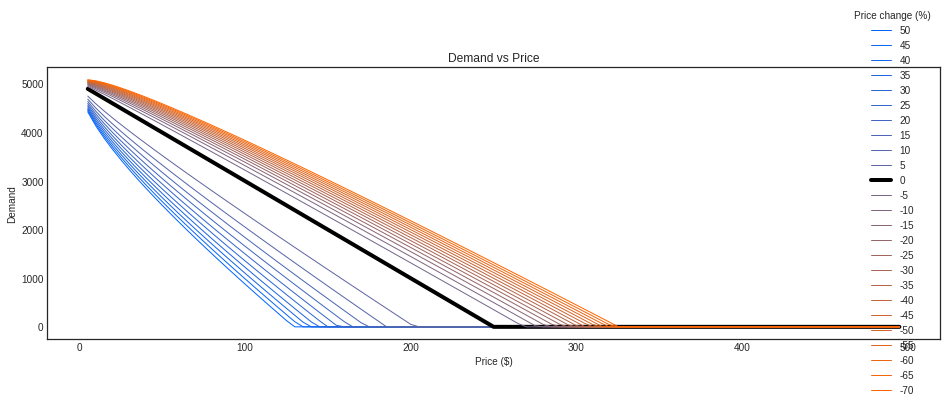

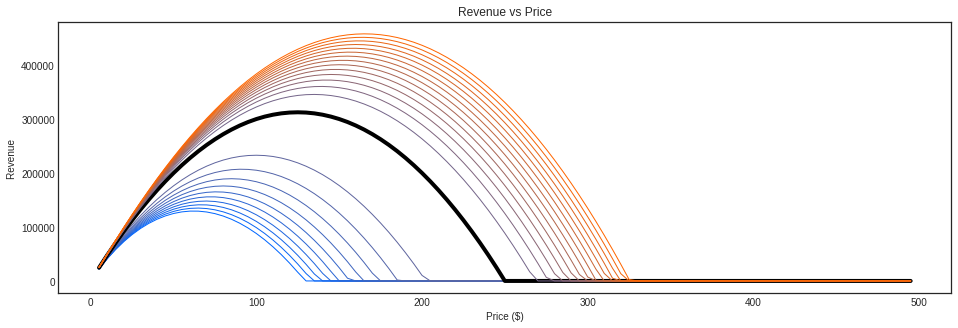

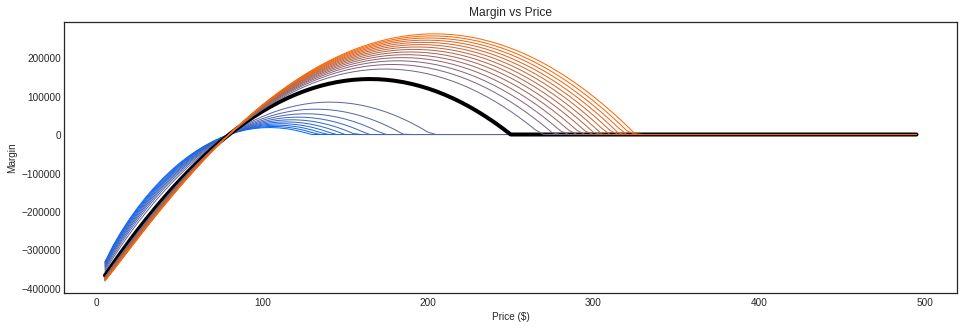

In [3]:
plt.figure(figsize=(16, 5))
for i, p_c in enumerate(price_changes):
    if math.isclose(p_c, 1.0):
        color = 'black'
        linewidth = 4.0
    else:
        p_norm = (p_c - min(price_changes))/ (max(price_changes) - min(price_changes))
        color = (p_norm, 0.4, 1 - p_norm)
        linewidth = 1.0
    plt.plot(price_levels, demand_matrix[:, i], c=color, linewidth = linewidth)
plt.xlabel("Price ($)")
plt.ylabel("Demand")
plt.title("Demand vs Price")
plt.legend(np.int_(np.round((1-price_changes)*100)), loc='right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.show()

plt.figure(figsize=(16, 5))
for i, p_c in enumerate(price_changes):
    if math.isclose(p_c, 1.0):
        color = 'black'
        linewidth = 4.0
    else:
        p_norm = (p_c - min(price_changes))/ (max(price_changes) - min(price_changes))
        color = (p_norm, 0.4, 1 - p_norm)
        linewidth = 1.0
    plt.plot(price_levels, revenue_matrix[:, i], c=color, linewidth = linewidth)
plt.xlabel("Price ($)")
plt.ylabel("Revenue ")
plt.title("Revenue vs Price")
plt.show()

plt.figure(figsize=(16, 5))
for i, p_c in enumerate(price_changes):
    if math.isclose(p_c, 1.0):
        color = 'black'
        linewidth = 4.0
    else:
        p_norm = (p_c - min(price_changes))/ (max(price_changes) - min(price_changes))
        color = (p_norm, 0.4, 1 - p_norm)
        linewidth = 1.0
    plt.plot(price_levels, margin_matrix[:, i], c=color, linewidth = linewidth)
plt.xlabel("Price ($)")
plt.ylabel("Margin")
plt.title("Margin vs Price")
plt.show()

# **Optimum Price and Margin for Static Price Level**

In [4]:
margins = np.array([margin_total_resp(np.repeat(price, T)) for price in price_levels])
p_opt_static = price_levels[np.argmax(margins)]
print(f'Optimal price is {p_opt_static}, achieved margin is {margins[np.argmax(margins)]}')

Optimal price is 165, achieved margin is 3034500.0


# **Optimum Price and Margin for Dynamic Price Levels**

## **Sequential Greedy Search**

[165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165
 165 165]
[165 495 215 180 170 165 495 215 180 170 165 495 215 180 170 165 495 215
 180 170]
Achieved profit is 3566604.0


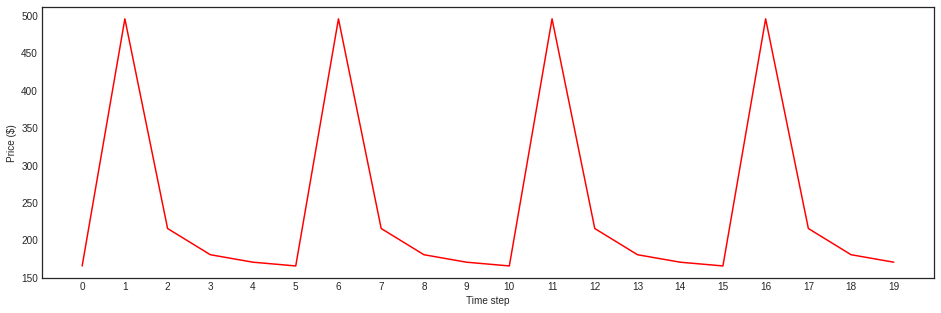

In [5]:
def find_opt_price_at_t(price_baseline, price_levels, t):
    _price_actuals = np.tile(price_baseline, (len(price_levels), 1))
    _price_actuals[:, t] = price_levels
#     print(_price_actuals, np.shape (_price_actuals))
    margins = np.array([margin_total_resp(prices) for prices in _price_actuals])
#     print(np.shape(margins))
    return price_levels[np.argmax(margins)]

p_opt_dyn_sched = np.repeat(p_opt_static, T)
print(p_opt_dyn_sched)
for t in range(T):
    price_t = find_opt_price_at_t(p_opt_dyn_sched, price_levels, t)
    p_opt_dyn_sched[t] = price_t

print(p_opt_dyn_sched)
print(f'Achieved profit is {margin_total_resp(p_opt_dyn_sched)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt_dyn_sched, c='red')
plt.show()

A simple **temporal dependency** inside the price-demand function dictates a complex pricing strategy with price surges and discounts. It can be viewed as a formal justification of the **Hi-Lo pricing strategy** used by many retailers; we see how altering regular and promotional prices helps to maximize profit.

The price-response function we have defined is essentially a differential equation where the profit depends not only on the current price action but also on the price dynamics. It's expected that such equations can exhibit very complex behavior, especially over long-time intervals, so the corresponding control policies can also become complex.

Optimization of such policies requires powerful, yet flexible methods, such as **deep reinforcement learning.**



# **Case Study 1: Pricing Policy Optimization using Deep Q Networks (DQN)**

Although the greedy search algorithm we implemented produces the optimal pricing schedule for a simple differential price-response function, as we add more constraints and interdependencies, it becomes increasingly more <u>challenging to reduce the problem to standard formulations, such as linear or integer programming.</u>

Let's approach the problem from a different perspective and apply a generic Deep Q Network (DQN) algorithm to learn the optimal price control policy.

We implement the basic version of DQN from scratch to provide a clearer picture of how DQN is applied to this particular environment and to demonstrate several debugging techniques. 

## **Defining the environment**

Reinforcement learning involves a setup where an agent interacts with the environment in discrete time steps with the goal of learning a reward-maximizing behavior policy. At each time step $t$, with a given state $s$, the agent takes an action $a$ according to its policy $\pi(s) \rightarrow a$ and receives the reward $r$ moving to the next state $s’$. 

Let's redefine our pricing environment in these reinforcement learning terms:

1. The **state** $s$ of the environment at any time step $t$ is a vector of prices of all previous time steps concatenated with the one-hot encoding of the time steps itself.
$s_t = \left( p_{t-1}, p_{t-2}, \ldots, p_{0} \right)\ |\ \left(0, \ldots, 1, \ldots, 0 \right)$

2. The **action** $a$ for every time step is just an index in the array of valid price levels. i.e. an array of shape (price_levels, time_steps)

3. The **reward** $r$ is the margin.

4. The goal is to find a policy that prescribes a pricing action based on the current state in a way that the total profit for a selling season (episode) is maximized.

## **Overview of the DQN algorithm**

The goal of the algorithm is to learn an action policy $\pi$ that maximizes the total discounted cumulative reward $R$ (aka the return) earned during the episode of $T$ time steps:

$R = \sum_{t=0}^T \gamma^t r_t$

Such a policy can be defined if we know a function that estimates the expected return based on the current state and next action, under the assumption that all subsequent actions will also be taken according to the policy:

$Q^{\pi}(s,a) = \mathbb{E}_{s,a}\left[R\right]$

Assuming that this Q-function is known, the policy can be straightforwardly defined as follows to maximize the return:

$\pi(s) = \underset{a}{\text{argmax}}\ Q(s,a)$

We can combine the above definitions into the following recursive equation (the Bellman equation):

$Q^{\pi}(s,a) = r + \gamma\max_{a'} Q(s', a')$

where $s'$ and $a'$ are the next state and next action taken in that state, respectively. If we estimate the Q-function using some approximator, then the quality of the approximation can be measured using the difference between the two sides of this equation:

$\delta = Q^{\pi}(s,a) - \left( r +\gamma\max_{a'} Q(s', a') \right)$

This is the **temporal difference error**. The main idea behind DQN is to train a deep neural network to approximate the Q-function using the temporal difference error as the loss function. 

In principle, the training process is quite straight forward:

1. Initialize the network. Its input corresponds to state representation, while output is a vector of Q-valuesfor all actions.

2. For each time step:
    1. Estimate Q-values.
    2. Execute the action with the maximum Q-value and observe the reward.
    3. Calculate the temporal difference error, and use it to derive the loss function.
    4. Update the network's parameters using stochastic gradient descent.
    
 This simple approach is unstable for training complex non-linear approximators, such as deep neural networks. Two techniques are used to address the issue:
 
 1. **Replay buffer**: One of the main problems with the basic training above is that the sequential observations are usually correlated, while network training generally requires independently distributed samples. DQN works around this by accumulating multiple observed transitions $(s, a, r, s')$ in a buffer and sampling batches of such transitions to retrain the network. The buffer is typically chosen large enough to minimize the correlations between samples.
 
 2. **Target networks**: The second problem is that the network parameters are updated based on the loss function computed using the Q-values produced by the same network. In other words, the learning target moves simultaneously with the parameters we are trying to learn, making the optimization process unstable. DQN mitigates this issuse by maintaining two instances of the network. The first one is used to take actions and is continuously updated as described above. The second one, called a target network, is a **lagged copy** of the first one and used specifically to calculate the Q-values for the loss function (i.e. the target). This technique helps to stabilize the learning process.
 
 3. **Action Selection Process**: The last concern that we need to address is how the action is chosen based on Q-values estimated by the network. A policy that always takes action with the maximum Q-value will not work well because the learning process will not sufficiently explore the environment, so we choose to randomize the action selection process. More specifically, we use $ε$-greedy policy that takes the action with the maximum Q-value with the probability of $1− ε$ and a random action with the probability of $ε$. We also use the annealing technique starting with a relatively large value of $ε$ and gradually decreasing it from one training episode to another.

## **Solution: Pricing Policy Optimization using DQN**

A standalone DQN-based optimizer using PyTorch

In [6]:
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque

from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transition = namedtuple("transition",
                        ("state", "action", "next_state", "reward"))

#a cyclic buffer of bounded size that holds the transitions observed recently


class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values


class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start=0.9, eps_end=0.05, eps_decay=400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (
            self.eps_start - self.eps_end) * math.exp(
                -1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))


GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512


def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(
        map(lambda s: s is not None, batch.next_state)),
                                  device=device,
                                  dtype=torch.bool)
    non_final_next_states = torch.stack(
        [s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(
        1)[0].detach()

    # compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA *
                                                         next_state_values)

    # compute huber loss
    loss = F.smooth_l1_loss(state_action_values,
                            expected_state_action_values.unsqueeze(1))

    # model optimizer
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


def env_initial_state():
    return np.repeat(0, 2 * T)


def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_levels[action]
    next_state[1:T] = state[:T - 1]
    next_state[T + t] = 1
    reward = margin_t_resp(next_state[0], next_state[1])
    return next_state, reward


def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))


def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)


policy_net = PolicyNetworkDQN(2 * T, len(price_levels)).to(device)
target_net = PolicyNetworkDQN(2 * T, len(price_levels)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayBuffer(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 1000
return_trace = []
p_trace = []  # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_initial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), to_tensor_long(action),
                    to_tensor(next_state) if t != T - 1 else None,
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_levels[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait=True)
        print(
            f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)'
        )

Episode 980 of 1000 (98.00%)


## **Visualizing and Debugging DQN Policy Training**

In [8]:
from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label
output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

Loading BokehJS ...

Best profit results: 3286054.0
Best profit results: 3288316.0
Best profit results: 3290866.0
Best profit results: 3308094.0
Best profit results: 3317746.0
[[35, 70, 40, 185, 140, 95, 205, 100, 375, 465, 220, 280, 205, 465, 225, 320, 375, 145, 75, 330], [255, 280, 150, 415, 430, 30, 165, 315, 200, 400, 480, 290, 470, 185, 375, 95, 355, 165, 130, 305]] (1000, 20)
[1021926.0, 1066567.0] (1000,)


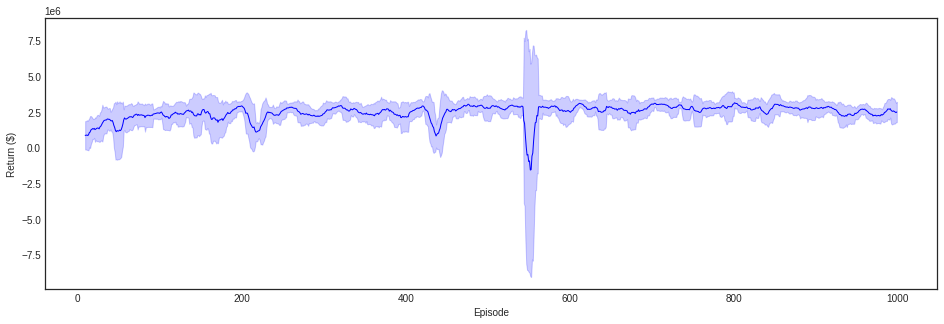

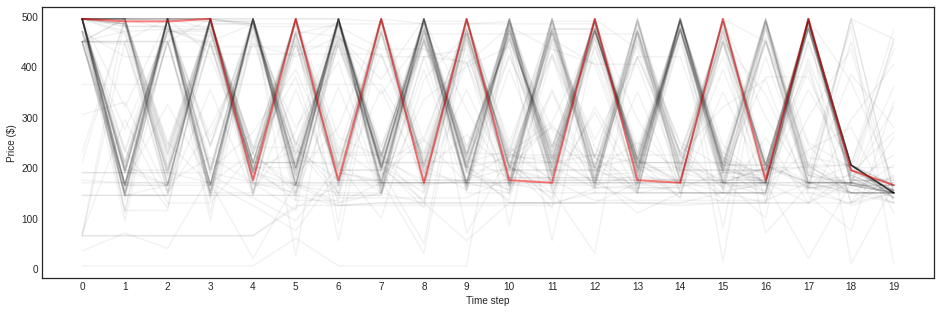

In [25]:
plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 10, 1, fig.number)

for margin in sorted(margin_total_resp(s) for s in p_trace)[-5:]:
    print(f'Best profit results: {margin}')
    
    
print(p_trace[:2], np.shape(p_trace))
print(return_trace[:2], np.shape(return_trace))

MovieWriter imagemagick unavailable; using Pillow instead.


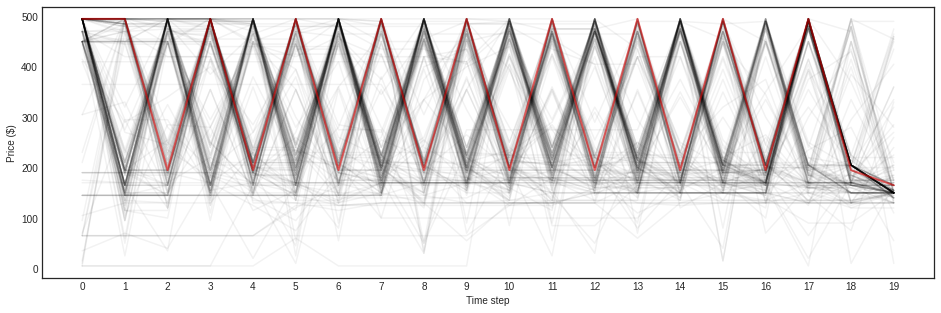

In [26]:
plt.ioff()
fig = plt.figure(figsize=(16, 5))
def animate(t):
    fig.clear()
    plot_price_schedules(p_trace[0:t], 5, 1, fig.number)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(10, 1000, 10), interval=50, blit=False, repeat_delay=500)
ani.save('sim.gif', dpi=80, writer='imagemagick', fps=20)
rc('animation', html='jshtml')

Optimal price action 495


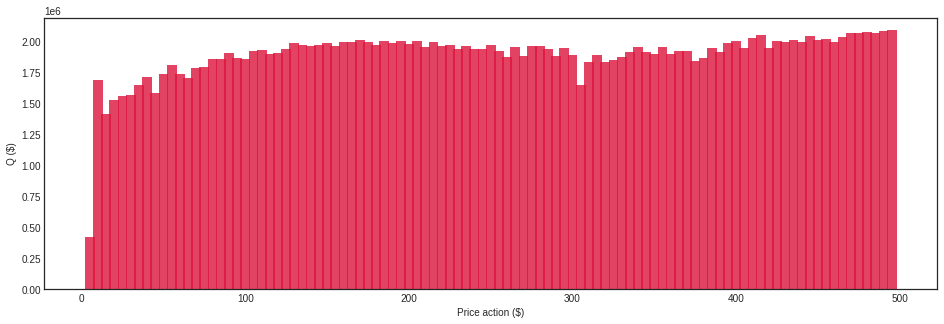

In [46]:
# Visualize Q values for a given state
sample_state = [170.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., \
                1.,     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]

Q_s = policy_net(to_tensor(sample_state))
a_opt = Q_s.max(0)[1].detach()
print(f"Optimal price action {price_levels[a_opt]}")

plt.figure(figsize=(16, 5))
plt.xlabel("Price action ($)")
plt.ylabel("Q ($)")
plt.bar(price_levels, Q_s.detach().numpy(), color='crimson',  width=6, alpha=0.8)
plt.show()

(100, 20, 2) (2000, 2)


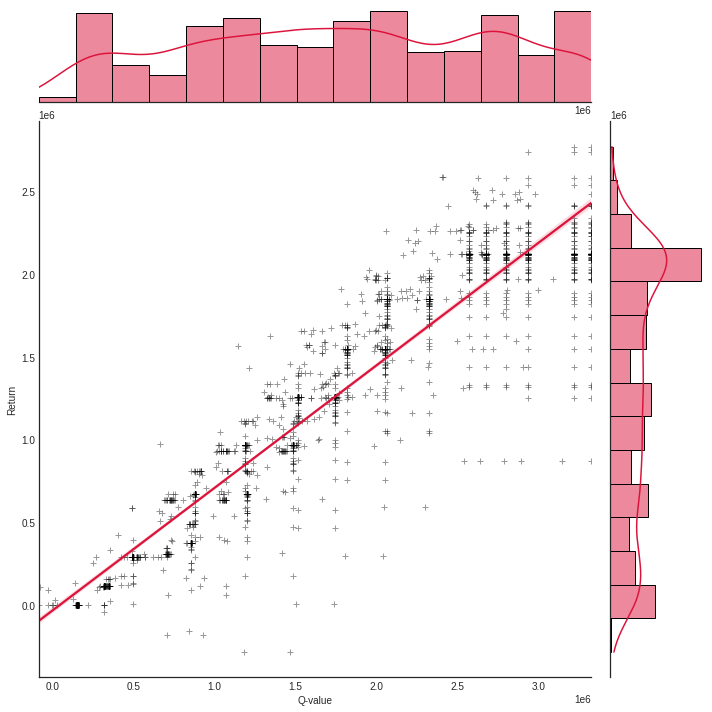

In [15]:
# Playing several episods and recording Q-values with the corresponding actual retunrs

num_episodes = 100
return_trace = []
q_values_rewards_trace = np.zeros((
    num_episodes,
    T,
    2,
))
for i_episode in range(num_episodes):
    state = env_initial_state()
    for t in range(T):
        #select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state)).detach().numpy()
            action = policy.select_action(q_values)
            next_state, reward = env_step(t, state, action)

            #move to the next state
            state = next_state
            q_values_rewards_trace[i_episode][t][0] = q_values[action]
            for tau in range(t):
                q_values_rewards_trace[i_episode][tau][1] += reward**(GAMMA**(
                    t - tau))

q_values = np.reshape(q_values_rewards_trace, (
    num_episodes * T,
    2,
))

print(np.shape(q_values_rewards_trace), np.shape(q_values))

df = pd.DataFrame(data=values, columns=['Q-value', 'Return'])
g = sns.jointplot(x="Q-value",
                  y="Return",
                  data=df,
                  kind="reg",
                  color="crimson",
                  height=10)
g.plot_joint(plt.scatter, c="k", s=30, linewidth=1, marker="+", alpha=0.4)
g.ax_joint.collections[0].set_alpha(0)

## **Solution: Implementing DQN Optimizer using RLLib**

In [40]:
from gym import Env
from gym.spaces import Discrete, Box
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


class PricingEnv(Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Discrete(len(price_levels))
        self.observation_space = Box(0,
                                     10000,
                                     shape=(2 * T, ),
                                     dtype=np.float32)

    def reset(self):
        self.state = env_initial_state()
        self.t = 0
        return self.state

    def step(self, action):
        next_state, reward = env_step(self.t, state, action)
        self.t += 1
        self.state = next_state
        return next_state, reward, self.t == T - 1, {}


ray.shutdown()
ray.init(dashboard_port=5000, local_mode=True, include_dashboard=True)


def train_dqn():
    config = dqn.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["lr"] = 0.002
    config["gamma"] = 0.80
    config["train_batch_size"] = 256
    config["buffer_size"] = 10000
    config["timesteps_per_iteration"] = 5000
    config["hiddens"] = [128, 128, 128]
    config["exploration_config"] = {
        'type': 'EpsilonGreedy',
        'initial_epsilon': 1.0,
        'final_epsilon': 0.02,
        'epsilon_timesteps': 10000
    }
    trainer = dqn.DQNTrainer(config=config, env=PricingEnv)
    error = []
    for i in range(50):
        result = trainer.train()
        error.append(result["info"]["learner"]["default_policy"]
                     ["learner_stats"]["mean_td_error"])
        print(np.mean(error))


train_dqn()

2021-07-01 18:03:16,952	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:5000
2021-07-01 18:03:22,619	WARNING util.py:53 -- Install gputil for GPU system monitoring.


184788.8
220058.47
234833.17
245486.31
237149.84
256172.94
280194.25
275602.1
272952.94
273452.44
273585.88
274338.62
274280.12
273311.94
271205.06
271382.97
271454.44
271352.7
272219.1
272830.66
272329.6
271637.28
268569.47
269374.66
267801.4
267105.34
267234.78
266490.88
265571.12
264934.44
265751.47
265528.38
264552.84
263072.8
262683.47
262882.06
262654.16
262462.7
262794.78
262110.08
262117.53
262205.12
262139.0
262394.44
262799.9
262535.03
262787.2
262850.12
262511.75
262505.7
